In [52]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

from keras.layers import Input, Concatenate, Dense, Activation, TextVectorization, Embedding, GlobalAveragePooling1D, SimpleRNN, GRU, LSTM
from keras.models import Model
import tensorflow as tf

# Camadas recorrentes no tempo

## Exercício 1
*Objetivo: explicar cada uma das etapas da classificação de textos usando embeddings*

O código abaixo mostra um classificador que usa embeddings. Explique com suas palavras cada uma das etapas do classificador (incluindo as etapas de pré-processamento, as camadas da rede e o pós-processamento), explicitando (a) o que a etapa faz e (b) por que ela é importante.

In [53]:
df = pd.read_csv('datasets/IMDB Dataset.csv').sample(1000)
ohe = OneHotEncoder()
y_ohe = ohe.fit_transform(df['sentiment'].to_numpy().reshape((-1,1))).todense()
X_train, X_test, y_train, y_test = train_test_split(df['review'], y_ohe)

In [54]:
vocab_size = 1000
def avg_embedding_softmax_model(vectorize_layer, vocab_size=vocab_size):
    input_layer = Input(shape=(1,), dtype=tf.string)
    x = input_layer
    x = vectorize_layer(x)
    x = Embedding(vocab_size, 2, name='projecao')(x)
    x = GlobalAveragePooling1D()(x)
    x = Dense(2, name='classificador')(x)
    x = Activation('softmax')(x)
    return Model(input_layer, x)

vectorize_layer = TextVectorization(output_mode='int', max_tokens=vocab_size, pad_to_max_tokens=True, output_sequence_length=200)
vectorize_layer.adapt(X_train)
clf = avg_embedding_softmax_model(vectorize_layer)
print(clf.summary())
clf.compile(loss='categorical_crossentropy', metrics=['accuracy'])
history = clf.fit(X_train, y_train, epochs=60, verbose=1, validation_split=0.1)
clf.evaluate(X_test, y_test)

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 1)]               0         
                                                                 
 text_vectorization_19 (Text  (None, 200)              0         
 Vectorization)                                                  
                                                                 
 projecao (Embedding)        (None, 200, 2)            2000      
                                                                 
 global_average_pooling1d_3   (None, 2)                0         
 (GlobalAveragePooling1D)                                        
                                                                 
 classificador (Dense)       (None, 2)                 6         
                                                                 
 activation_15 (Activation)  (None, 2)                 0  

[0.654585599899292, 0.6880000233650208]

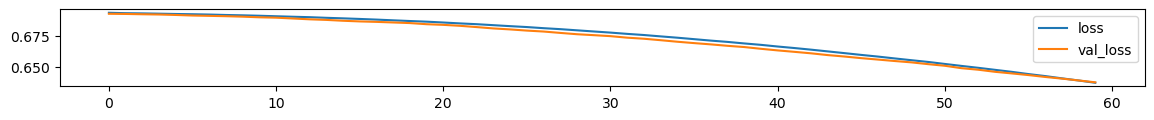

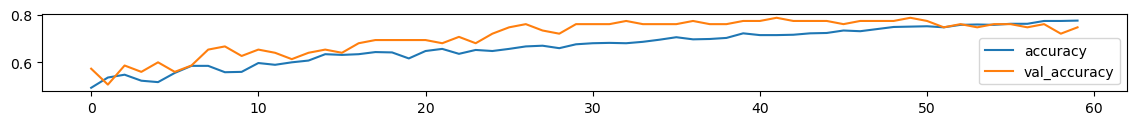

In [55]:
plt.figure(figsize=(14,1))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()
plt.figure(figsize=(14,1))
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()


## Exercício 2
*Objetivo: usar uma rede recorrente para o problema de predição*

Até o momento, usamos a média para "resumir" nossas sequências de vetores de embeddings para um único vetor. Apesar de ser uma solução computacionalmente simples e que gera embeddings interpretáveis, também é uma solução que pode ser entendida como "inocente", porque ignora a ordem das palavras.

Uma outra ideia para isso é usar uma rede recorrente.

As rede recorrentes funcionam guardando um estado $e_t$ para cada instante de tempo. Esse estado é atualizado com base no estado anterior e na palavra lida na entrada, isto é:

$$
e_t = f(x_t, e_{t-1})
$$

A rede passa adiante o estado no último instante de tempo.

Como o desempenho e a curva de aprendizado das rede recorrente simples (`SimpleRNN`) se compara com aquele que tivemos ao usar a camada `GlobalAveragePooling1D`?

In [56]:
vocab_size = 1000
def rnn_softmax_model(vectorize_layer, vocab_size=vocab_size):
    input_layer = Input(shape=(1,), dtype=tf.string)
    x = input_layer
    x = vectorize_layer(x)
    x = Embedding(vocab_size, 2, name='projecao')(x)
    x = SimpleRNN(1)(x)
    x = Dense(2, name='classificador')(x)
    x = Activation('softmax')(x)
    return Model(input_layer, x)

vectorize_layer = TextVectorization(output_mode='int', max_tokens=vocab_size, pad_to_max_tokens=True, output_sequence_length=200)
vectorize_layer.adapt(X_train)
clf = rnn_softmax_model(vectorize_layer)
print(clf.summary())
clf.compile(loss='categorical_crossentropy', metrics=['accuracy'])
history = clf.fit(X_train, y_train, epochs=60, verbose=1, validation_split=0.1)
clf.evaluate(X_test, y_test)

Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 1)]               0         
                                                                 
 text_vectorization_20 (Text  (None, 200)              0         
 Vectorization)                                                  
                                                                 
 projecao (Embedding)        (None, 200, 2)            2000      
                                                                 
 simple_rnn_6 (SimpleRNN)    (None, 1)                 4         
                                                                 
 classificador (Dense)       (None, 2)                 4         
                                                                 
 activation_16 (Activation)  (None, 2)                 0         
                                                          

[0.7285000681877136, 0.6959999799728394]

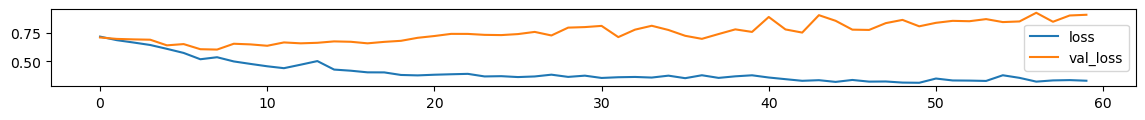

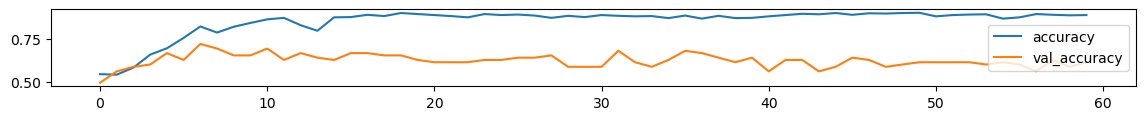

In [57]:
plt.figure(figsize=(14,1))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()
plt.figure(figsize=(14,1))
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()


# Exercício 3
*Objetivo: usar uma GRU para resumir embeddings no tempo*

Um problema da RNN simples é que o impacto de uma palavra no resultado final da camada decai exponencialmente. Para tentar mitigar esse problema, outras variações de redes recorrentes foram desenvolvidas.

Uma delas é a GRU, que segue o seguinte diagrama:

<img src="gru.png" width=600px style="background-color:white" />

Na figura acima, identifique:

1. Uma rede neural com ativação $\tanh()$, que calcula o próximo estado com base no estado anterior e na entrada atual.
1. Uma estrutura chamada "carrossel de erro", na qual o estado anterior se propaga para o estado posterior sem passar por nenhuma linearidade.
1. Uma estrutura chamada "gate de reset", que aplica uma rede neural com ativação sigmoidal para modular o quanto da entrada será usado para calcular o próximo estado.
1. Uma  estrutura chamada "gate de update", que aplica uma rede neural com ativação sigmoidal para ponderar o estado atual e o novo estado calculado para gerar o próximo estado.

Como o desempenho e as curvas de treinamento da rede se comparam com os casos anteriores?

In [58]:
vocab_size = 1000
def gru_softmax_model(vectorize_layer, vocab_size=vocab_size):
    input_layer = Input(shape=(1,), dtype=tf.string)
    x = input_layer
    x = vectorize_layer(x)
    x = Embedding(vocab_size, 2, name='projecao')(x)
    x = GRU(1)(x)
    x = Dense(2, name='classificador')(x)
    x = Activation('softmax')(x)
    return Model(input_layer, x)

vectorize_layer = TextVectorization(output_mode='int', max_tokens=vocab_size, pad_to_max_tokens=True, output_sequence_length=200)
vectorize_layer.adapt(X_train)
clf = gru_softmax_model(vectorize_layer)
print(clf.summary())
clf.compile(loss='categorical_crossentropy', metrics=['accuracy'])
history = clf.fit(X_train, y_train, epochs=60, verbose=1, validation_split=0.1)
clf.evaluate(X_test, y_test)

Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 1)]               0         
                                                                 
 text_vectorization_21 (Text  (None, 200)              0         
 Vectorization)                                                  
                                                                 
 projecao (Embedding)        (None, 200, 2)            2000      
                                                                 
 gru_2 (GRU)                 (None, 1)                 15        
                                                                 
 classificador (Dense)       (None, 2)                 4         
                                                                 
 activation_17 (Activation)  (None, 2)                 0         
                                                          

[0.7018887996673584, 0.6480000019073486]

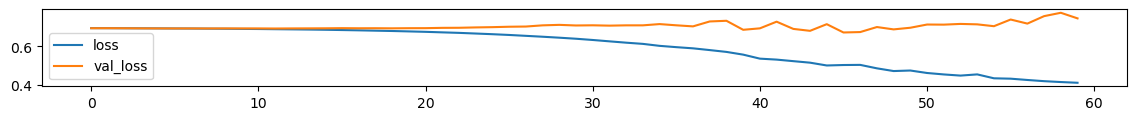

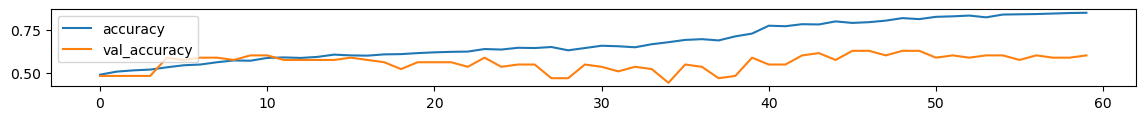

In [59]:
plt.figure(figsize=(14,1))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()
plt.figure(figsize=(14,1))
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()


# Exercício 4
*Objetivo: usar uma LSTM para resumir embeddings no tempo*

Uma outra proposta para resumir vetores no tempo é a LSTM. Ela segue o seguinte diagrama:

<img src="lstm.png" width=600px style="background-color:white" />

Na LSTM, temos dois estados internos: $C$ e $H$. Na rede, encontre:

1. Uma estrutura chamada "carrossel de erro", na qual o estado anterior se propaga para o estado posterior sem passar por nenhuma não-linearidade.
1. Uma rede neural com ativação $\tanh()$, que calcula o próximo estado C com base no estado anterior H e na entrada atual.
1. Uma rede neural com ativação $\tanh()$, que calcula o próximo estado H com base somente no estado anterior C.
1. Uma estrutura chamada "forget gate", que calcula o quanto do estado atual C será usada para calcular o próximo estado C.
1. Uma estrutura chamada "input gate", que aplica uma rede neural com ativação sigmoidal para modular o quanto do estado calculado com base em X e H será usado para modificar C.
1. Uma  estrutura chamada "output gate", que é capaz de anular a próxima saída do estado H com base em X e H.

Como o desempenho e as curvas de treinamento da rede se comparam com os casos anteriores?

In [60]:
vocab_size = 1000
def lstm_softmax_model(vectorize_layer, vocab_size=vocab_size):
    input_layer = Input(shape=(1,), dtype=tf.string)
    x = input_layer
    x = vectorize_layer(x)
    x = Embedding(vocab_size, 2, name='projecao')(x)
    x = LSTM(1)(x)
    x = Dense(2, name='classificador')(x)
    x = Activation('softmax')(x)
    return Model(input_layer, x)

vectorize_layer = TextVectorization(output_mode='int', max_tokens=vocab_size, pad_to_max_tokens=True, output_sequence_length=200)
vectorize_layer.adapt(X_train)
clf = lstm_softmax_model(vectorize_layer)
print(clf.summary())
clf.compile(loss='categorical_crossentropy', metrics=['accuracy'])
history = clf.fit(X_train, y_train, epochs=60, verbose=1, validation_split=0.1)
clf.evaluate(X_test, y_test)

Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 1)]               0         
                                                                 
 text_vectorization_22 (Text  (None, 200)              0         
 Vectorization)                                                  
                                                                 
 projecao (Embedding)        (None, 200, 2)            2000      
                                                                 
 lstm_13 (LSTM)              (None, 1)                 16        
                                                                 
 classificador (Dense)       (None, 2)                 4         
                                                                 
 activation_18 (Activation)  (None, 2)                 0         
                                                          

[0.6188330054283142, 0.7120000123977661]

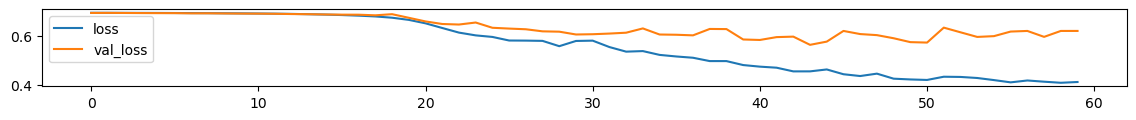

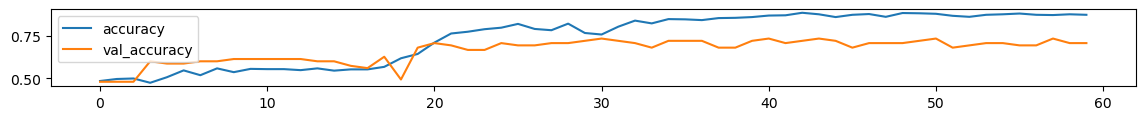

In [61]:
plt.figure(figsize=(14,1))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()
plt.figure(figsize=(14,1))
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()


# Exercício 5
*Objetivo: usar uma rede LSTM bidirecional*

Uma característica das redes recorrentes é que elas usam somente informação do passado. Porém, talvez quiséssemos um tipo de agregação que usa informações vindas "do futuro". Talvez queiramos encontrar situações em que a palavra que segue a palavra "a" seja determinante de seu significado, por exemplo.

Para isso, podemos usar uma camada recorrente que caminha "ao contrário" na sequência de entrada.

1. No código abaixo, identifique a camada LSTM que caminha ao contrário.
1. Como a informação desse camada é usada?

In [62]:
vocab_size = 1000
def blstm_softmax_model(vectorize_layer, vocab_size=vocab_size):
    input_layer = Input(shape=(1,), dtype=tf.string)
    x = input_layer
    x = vectorize_layer(x)
    x = Embedding(vocab_size, 2, name='projecao')(x)
    x1 = LSTM(1)(x)
    x2 = LSTM(1, go_backwards=True)(x)
    x = Concatenate()([x1, x2])
    x = Dense(2, name='classificador')(x)
    x = Activation('softmax')(x)
    return Model(input_layer, x)

vectorize_layer = TextVectorization(output_mode='int', max_tokens=vocab_size, pad_to_max_tokens=True, output_sequence_length=200)
vectorize_layer.adapt(X_train)
clf = blstm_softmax_model(vectorize_layer)
print(clf.summary())
clf.compile(loss='categorical_crossentropy', metrics=['accuracy'])
history = clf.fit(X_train, y_train, epochs=60, verbose=1, validation_split=0.1)
clf.evaluate(X_test, y_test)

Model: "model_19"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_24 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 text_vectorization_23 (TextVec  (None, 200)         0           ['input_24[0][0]']               
 torization)                                                                                      
                                                                                                  
 projecao (Embedding)           (None, 200, 2)       2000        ['text_vectorization_23[0][0]']  
                                                                                                  
 lstm_14 (LSTM)                 (None, 1)            16          ['projecao[0][0]']        

[0.6058294773101807, 0.699999988079071]

# Exercício 6
*Objetivo: testar a relevância da ordem das palavras nas redes recorrentes*

As redes recorrentes que treinamos, potencialmente, usam a informação de ordem das palavras para melhorar suas predições. Porém, não temos, até o momento, nenhuma prova de que elas, de fato, são afetadas ou, ainda, que são melhoradas por analisar a ordem das palavras que ocorrem. Uma possível maneira de testar isso é embaralhar a ordem das palavras em nossos dados de teste e verificar o que acontece com o desempenho da rede. 

O código abaixo embaralha palavras no conjunto de teste. O que acontece com o desempenho, e como você explicaria isso?

In [88]:
import random
X_test_shuffle = pd.Series([' '.join( random.sample(X_test.iloc[i].split(), len(X_test.iloc[i].split())) ) for i in range(len(X_test))])